In [1]:
import os
import glob
import PIL
import PIL.Image
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, BatchNormalization
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
#There are two types of lung xray cases, Normal and Pneumonia
labels = ["NORMAL", "PNEUMONIA"]i
mg_size = 150

#Location of images
train_folder = './chest_xray/train'
test_folder = './chest_xray/test'
val_folder = './chest_xray/val'

normal_cases = []
pneumonia_cases = []

#We will use a image data generator for training later but for now we want to grab some images to look at
for label in labels:
    path = os.path.join(train_folder, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (img_size, img_size))
        if class_num == 0:
            normal_cases.append([new_array, class_num])
        else:
            pneumonia_cases.append([new_array, class_num])
            
#Lets count the amount of each case
normal_cases = np.array(normal_cases)
pneumonia_cases = np.array(pneumonia_cases)

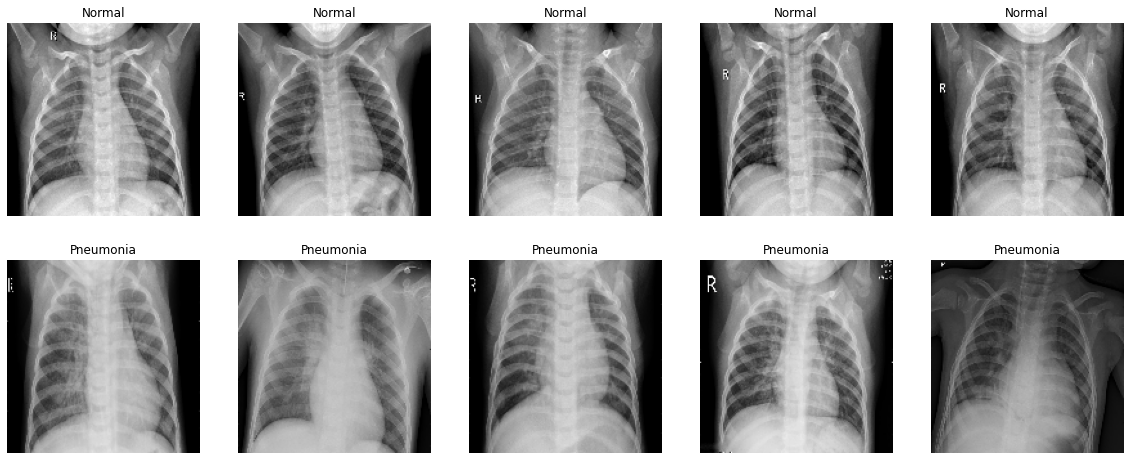

In [3]:
#Lets look at some examples of Normal vs Pneuonia xrays

plt.figure(figsize=(20, 8))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    if i < 5:
        plt.imshow(normal_cases[i][0].astype("uint8"))
        plt.title("Normal")
    else:
        plt.imshow(pneumonia_cases[i][0].astype("uint8"))
        plt.title("Pneumonia")        
    plt.axis("off")

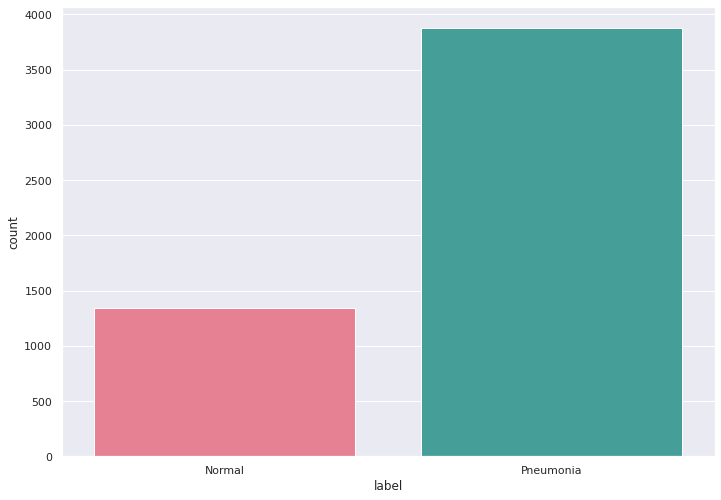

In [4]:
#There are significantly more pneumonia cases than normal cases, we will use a weight to balance this for training

all_cases = pd.DataFrame(data=np.concatenate((normal_cases,pneumonia_cases),axis=0),columns = ['img','label'])
for index, row in all_cases.iterrows():
    row['label'] = 'Pneumonia' if row['label'] == 1 else 'Normal'
    
sns.set_style("dark")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(x="label", data=all_cases,palette="husl")

In [5]:
#The weight mentioned earlier

weight_0 = (1 / len(normal_cases))*len(all_cases)/2.0 
weight_1 = (1 / len(pneumonia_cases))*len(all_cases)/2.0

class_weight = {0: weight_0, 1: weight_1}

In [6]:
#Loading the data for training, utilizing batches and normalizing the images

datagen = ImageDataGenerator(rescale = 1./255)

train_set = datagen.flow_from_directory(train_folder,
                                           target_size = (img_size, img_size),
                                           batch_size = 32,
                                           class_mode = 'binary')

val_set = datagen.flow_from_directory(val_folder,
                                      target_size=(img_size, img_size),
                                      batch_size=32,
                                      class_mode='binary')

test_set = datagen.flow_from_directory(test_folder,
                                       target_size = (img_size, img_size),
                                       batch_size = 32,
                                       class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
#We will use transfer learning
base_model = Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_size,img_size,3),
    include_top=False,
)

base_model.trainable = False

inputs = Input(shape=(img_size,img_size,3))
x = inputs
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = Model(inputs, outputs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
83689472/83683744 [==============================] - 3s 0us/step


In [8]:
model.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
history = model.fit_generator(train_set,
                    steps_per_epoch = int( np.ceil(train_set.n / 32) ),
                    epochs = 5,
                    validation_data = val_set,
                    validation_steps = int( test_set.n ),
                    class_weight=class_weight)

Epoch 1/5
163/163 [==============================] - 766s 5s/step - loss: 0.0939 - acc: 0.9624 - val_loss: 0.5096 - val_acc: 0.8750
Epoch 2/5
163/163 [==============================] - 762s 5s/step - loss: 0.0895 - acc: 0.9628 - val_loss: 0.3892 - val_acc: 0.8125
Epoch 3/5
163/163 [==============================] - 763s 5s/step - loss: 0.0880 - acc: 0.9664 - val_loss: 0.5146 - val_acc: 0.8750
Epoch 4/5
163/163 [==============================] - 767s 5s/step - loss: 0.0867 - acc: 0.9661 - val_loss: 0.5383 - val_acc: 0.7500
Epoch 5/5
163/163 [==============================] - 765s 5s/step - loss: 0.0840 - acc: 0.9670 - val_loss: 0.4131 - val_acc: 0.8125


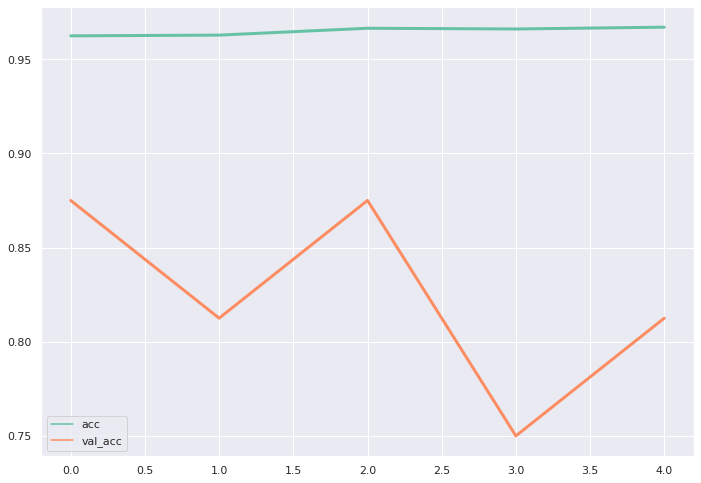

In [56]:
#Lets look at how our model did, seems to overfit a bit...
history_df = pd.DataFrame(data=history.history,columns = ['acc','val_acc'])
ax = sns.lineplot(data=history_df,palette="Set2",linewidth = 3,dashes=False)

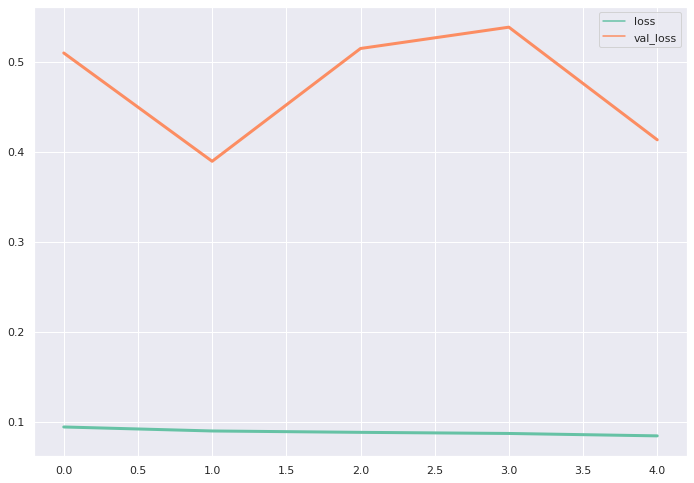

In [57]:
#Now we compare loss...
history_df = pd.DataFrame(data=history.history,columns = ['loss','val_loss'])
ax = sns.lineplot(data=history_df,palette="Set2",linewidth = 3,dashes=False)